Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 6: Using Neural Networks for Classification and Land Cover Mapping
===========================================================

Deep learning may be equal parts overhyped and underutilized (https://doi.org/10.1038/nature14539), but is undoubtedly a powerful set of tools for analyzing huge reams of data. Applications are growing rapidly in remote sensing (https://doi.org/10.1109/MGRS.2017.2762307) and in particular it is permitting new and exciting applications in areas like anomaly detection (https://doi.org/10.1109/TGRS.2018.2872509), image classification (https://doi.org/10.1109/TGRS.2016.2612821), and biophysical variable regression (https://doi.org/10.3390/rs11070768). Here we present a simple example of landcover classification using Landsat 8, the National Landcover Dataset as training data, and a simple convolutional neural network.

## Overview

*   create utility functions
*   import data
*   import training data
*   explore the data
*   run some baseline classifications with k-nearest neighbors and random forest 
*   build a simple CNN
*   evaluate the model

Before diving into this please note that it can take much more significant computing resources to (e.g. a decent GPU) to run this code in a reasonable time. Luckily you can simply run this in Google's Colab environment here: https://colab.research.google.com/github/patrickcgray/open-geo-tutorial/blob/master/notebooks/chapter_6_neural_networks.ipynb

Let's start!

In [1]:
# If running this in CoLab this will be necessary to set up your VM correctly
# if so, uncomment the line below
# ! pip install geopandas rasterio matplotlib descartes scikit-learn

### Create all the Utility Functions We'll Need:

#### First we'll create a random pixel generator for training and validation

In [2]:
import random
import math
import itertools

from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
%matplotlib inline

from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
import rasterio.features
import rasterio.warp
import rasterio.mask

from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon

def gen_balanced_pixel_locations(image_datasets, train_count, label_dataset, merge=False):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    label_proj = Proj(label_dataset.crs)    
    train_pixels = []
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        # how many points from each class
        points_per_class = train_count_per_dataset // len(np.unique(merge_classes(labels_image)))
        
        # get landsat boundaries in this image
        # create approx dataset mask in geographic coords
        # this fcn maps pixel locations in (row, col) coordinates to (x, y) spatial positions
        raster_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)
        l8_proj = Proj(image_dataset.crs)
        new_raster_points = []
        # convert the raster bounds from landsat into label crs
        for x,y in raster_points:
            x,y = transform(l8_proj,label_proj,x,y)
            # convert from crs into row, col in label image coords
            row, col = label_dataset.index(x, y)
            # don't forget row, col is actually y, x so need to swap it when we append
            new_raster_points.append((col, row))
        # turn this into a polygon
        raster_poly = Polygon(new_raster_points)
        # Window.from_slices((row_start, row_stop), (col_start, col_stop))
        masked_label_image = label_dataset.read(window=Window.from_slices((int(raster_poly.bounds[1]), int(raster_poly.bounds[3])), (int(raster_poly.bounds[0]), int(raster_poly.bounds[2]))))
        if merge:
            masked_label_image = merge_classes(masked_label_image)
        # loop for each class
        all_points_per_image = []
        for cls in np.unique(merge_classes(labels_image)):
            cls = int(cls)
            # mask the label subset image to each class
            # pull out the indicies where the mask is true
            rows,cols = np.where(masked_label_image[0] == cls)
            all_locations = list(zip(rows,cols))
       
            # shuffle all locations
            random.shuffle(all_locations)
            # now convert to landsat image crs
            # TODO need to time this to see if it is slow, can probably optimize
            l8_points = []
            # TODO Will probably need to catch this for classes smaller than the ideal points per class
            if len(all_locations)!=0:
                for r,c in all_locations[:points_per_class]:
                # convert label row and col into label geographic space
                    x,y = label_dataset.xy(r+raster_poly.bounds[1],c+raster_poly.bounds[0])
                # go from label projection into landsat projection
                    x,y = transform(label_proj, l8_proj,x,y)
                # convert from landsat geographic space into row col
                    r,c = image_dataset.index(x,y)
                    l8_points.append((r,c))
                all_points_per_image += l8_points

        dataset_index_list = [index] * len(all_points_per_image)

        dataset_pixels = list(zip(all_points_per_image, dataset_index_list))
        train_pixels += dataset_pixels
    random.shuffle(train_pixels)
    return (train_pixels)

print("Code loaded")


Code loaded


#### Next a tile generator to take those pixel locations and build tiles of the right format. 

This generator is handed directly to the `keras` model and continually feeds data to the model during training and validation. 

In [3]:
def tile_generator(l8_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=False):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
     

    c = r = 0
    i = 0
    
    label_proj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count  
    band_count = l8_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if tile.size == 0:
                pass
            elif np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                #print('wrong shape')
                #print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:                
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile)  - 982.5) / 1076.5

                ### get label data
                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != label_proj:
                    x,y = transform(l8_proj,label_proj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data = merge_classes(label_dataset.read(1, window=window, masked=False, boundless=True))
                label = data[0,0]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:                   
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)

print("Code loaded!")


Code loaded!


#### Next a function to build a more visually appealing confusion matrix than the default one.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("Code loaded!")


Code loaded!


#### Finally a function to merge the NLCD classes into a more manageable subset.

In [5]:
def merge_classes(y):
    # reclassify 255 to 0
    y[y == 255] = 0
    # medium intensity and high intensity
    y[y == 3] = 2
    # low intensity and high intensity
    y[y == 4] = 2

    # open space developed, cultivated land, and pasture hay
    y[y == 5] = 6
    y[y == 7] = 6

    # decidious and mixed
    y[y == 9] = 11
    # evergreen to mixed
    y[y == 10] = 11
    # shrub and mixed
    y[y == 12] = 11
    # wetland forest to mixed
    y[y == 13] = 11
    # pal wetland and pal scrub shrub
    y[y == 14] = 18
    y[y == 15] = 18
    y[y == 16] = 18
    y[y == 17] = 18
    
    # pal bed to water
    y[y == 22] = 21
    # unconsol shore to water
    y[y == 19] = 21
    
    return(y)

print("Code loaded!")


Code loaded!


#### Dictionary of all classes and class IDs

In [6]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

print("Code executed!")


Code executed!


### With that out of the way let's get started!

Inspect the landsat data:

In [7]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open our raster dataset
landsat_dataset = rasterio.open('../data/landsat_image.tif')

# How many bands does this image have?
num_bands = landsat_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = landsat_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = landsat_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = landsat_dataset.crs
print('Image projection:')
print(proj)


Number of bands in image: 8

Image size is: 4475 rows x 1481 columns

Raster driver: GTiff

Image projection:
PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


Open up the dataset and read it into memory:

In [8]:
landsat_image = landsat_dataset.read()
landsat_image.shape


(8, 4475, 1481)

Let's calculate NDVI:

In [9]:
bandNIR = landsat_image[4, :, :]
bandRed = landsat_image[3, :, :]

ndvi = np.clip((bandNIR.astype(float) - bandRed.astype(float)) / (bandNIR.astype(float) + bandRed.astype
                                                                  (float)), -1,1)

print("Code executed!")


Code executed!


In [10]:
print('\nMax NDVI: {m}'.format(m=ndvi.max()))
print('Mean NDVI: {m}'.format(m=ndvi.mean()))
print('Median NDVI: {m}'.format(m=np.median(ndvi)))
print('Min NDVI: {m}'.format(m=ndvi.min()))



Max NDVI: 1.0
Mean NDVI: -0.11445379226750008
Median NDVI: -0.1590909090909091
Min NDVI: -1.0


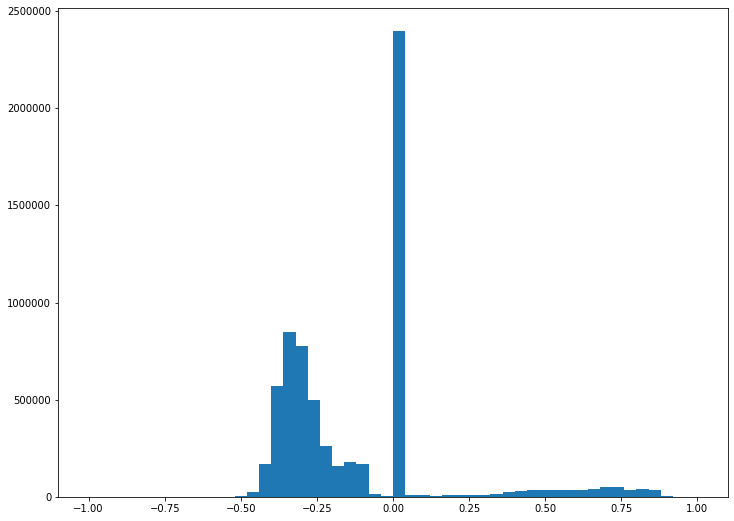

In [11]:
fig, axs = plt.subplots(figsize=(12,9))

# We can set the number of bins with the `bins` kwarg
_ = axs.hist(ndvi.flatten(), bins=50)
# fig.show()
plt.show()


NDVI looks normal, let's check out the whole image histogram:

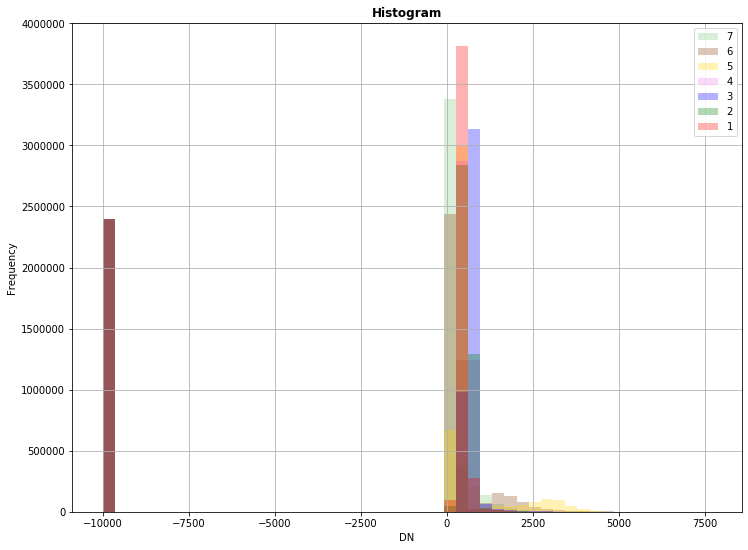

In [12]:
plt.figure(figsize=(12,9))
rasterio.plot.show_hist(landsat_dataset.read([1,2,3,4,5,6,7]), 
                        bins=50, 
                        histtype='stepfilled', 
                        lw=0.0, 
                        stacked=False, 
                        alpha=0.3)


Now we'll visualize the landsat image and NDVI side by side:

(3, 4475, 1481)
(4475, 1481, 3)


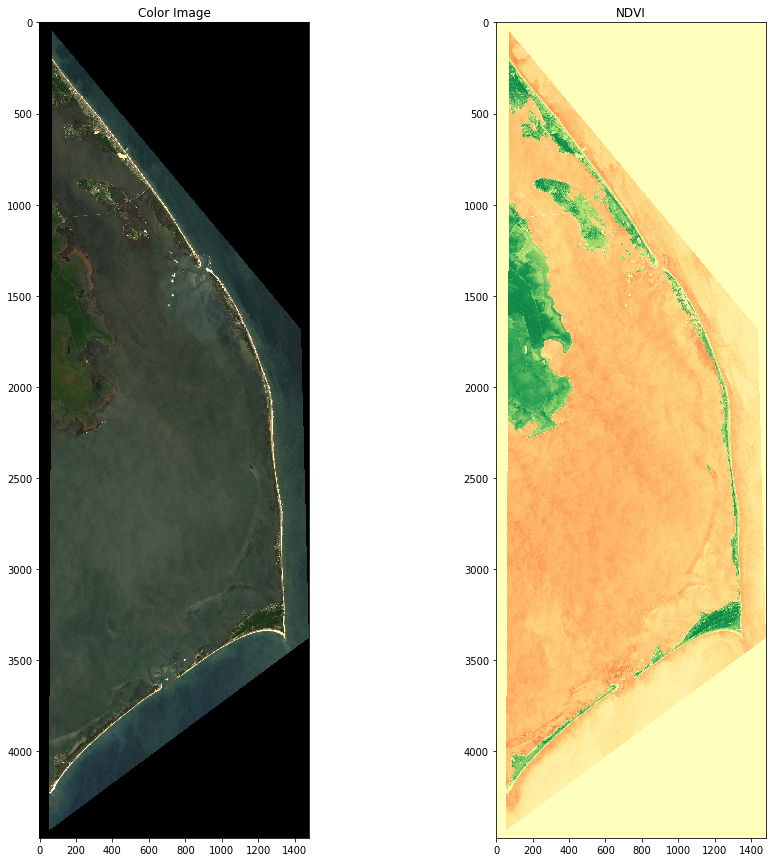

In [13]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show

# pull out the bands we want to visualize
index = np.array([3, 2, 1])
colors = landsat_image[index, :, :].astype(np.float64)

# we'll use the values to stretch the landsat image based on the above histogram
max_val = 2500
min_val = 0

# enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)


fig, axs = plt.subplots(1, 2, figsize=(15, 15)) 

# Show the color image
axs[0].imshow(colors_reshaped)
axs[0].set_title('Color Image')

# Show NDVI
axs[1].imshow(ndvi, cmap='RdYlGn')
axs[1].set_title('NDVI')

#fig.show()
plt.show()


Now let's check out the quality band

[  0   1 322 324 328 352 386 388 392 416 480]


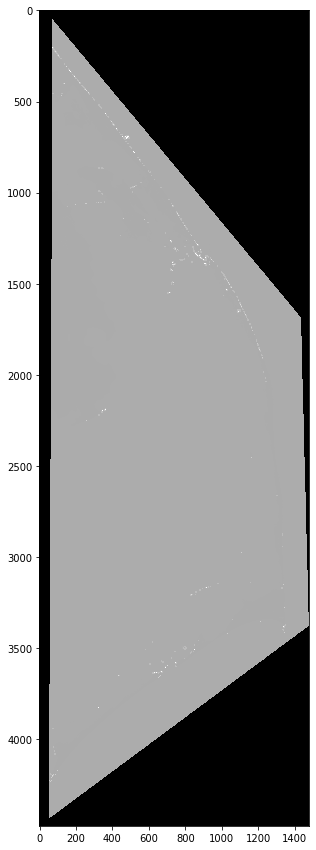

In [15]:
qa_band = landsat_image[7, :, :]
qa_band[qa_band == -9999] = 0

print(np.unique(qa_band))

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(qa_band, cmap='gray')


Read in the training labels image

In [16]:
labels_dataset = rasterio.open('../data/labels_image.tif')
# we're merging here just to limit the number of classes we're working with
labels_image = merge_classes(labels_dataset.read())
labels_image.shape


(1, 4476, 1482)

How many pixels are there of each class?

In [17]:
unique, counts = np.unique(labels_image, return_counts=True)
list(zip(unique, counts))


[(0, 2189505),
 (2, 53319),
 (6, 15131),
 (8, 6340),
 (11, 233678),
 (18, 272903),
 (20, 40077),
 (21, 3822479)]

Let's view the training labels:

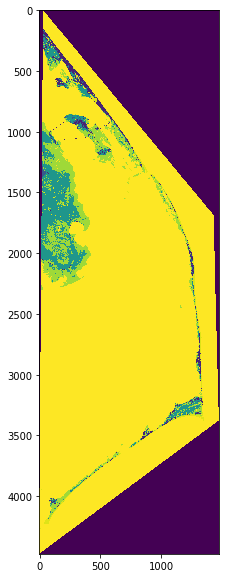

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
# we then use these objects to draw-on and manipulate our plot
ax.imshow(labels_image[0])


Now with a more logical color map:


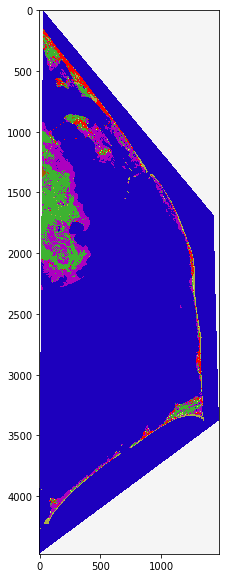

In [19]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (40, 40, 40)), # Pal Bed
))

n = int(np.max(labels_image)) + 1


# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(figsize=(10,10))

axs.imshow(labels_image[0,:, :], cmap=cmap, interpolation='none')


Generate a set of random class balanced pixel locations:

In [21]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

train_pixels = gen_balanced_pixel_locations([landsat_dataset], train_count=8000, 
                                            label_dataset=labels_dataset, merge=True)


100%|██████████| 1/1 [20:49<00:00, 1249.70s/it]


This code takes a while to run and isn't necessary to run the CNN, But it is good practice to ensure you have a balanced and correct dataset. It also is a nice sanity check to map out the actual location of the pixels.

In [22]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
landsat_datasets = [landsat_dataset]
# generate the training and validation pixel locations
all_labels = []
label_locations = []
for pixel in train_pixels:
    # row, col location in landsat
    r,c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(labels_dataset.crs)
    # geographic location in landsat
    x,y = landsat_datasets[ds_index].xy(r,c)
    # go from label projection into landsat projection
    x,y = transform(l8_proj, label_proj ,x,y)
    # get row and col location in label
    r,c = labels_dataset.index(x,y)
    label_locations.append([r,c])
    # format (bands, height, width)
    window = ((r, r+1), (c, c+1))
    data = merge_classes(labels_dataset.read(1, window=window, masked=False, boundless=True))
    all_labels.append(data[0,0])
label_locations = np.array(label_locations)
unique, counts = np.unique(np.array(all_labels), return_counts=True)
dict(zip(unique, counts))
print("Code executed!")


Code executed!


Visualize the location of those pixels on the label image:

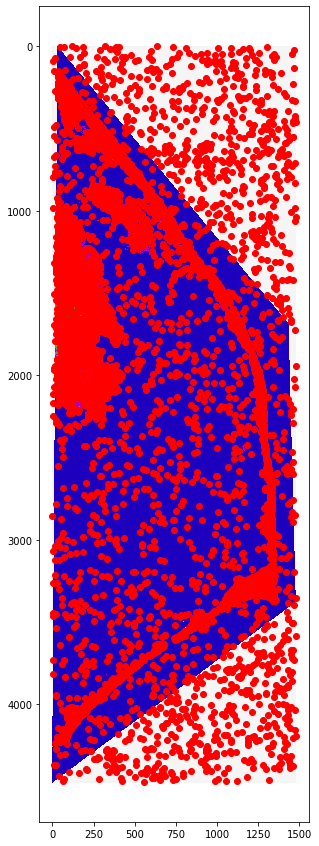

In [23]:
fig, ax = plt.subplots(figsize=[15,15])

ax.imshow(labels_image[0,:, :], cmap=cmap, interpolation='none')

plt.scatter(label_locations[:, 1], label_locations[:, 0], c='r')


Note that there are lots of pixels generated in areas that don't actually have data. We'll filter that out in the data generator.

#### Test out the generator:

Print out some image and label batches and check out their shapes.

In [24]:
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    

Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----


Now let's visualize the actual tiles. Note they'll look unnatural because they have been normalized.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


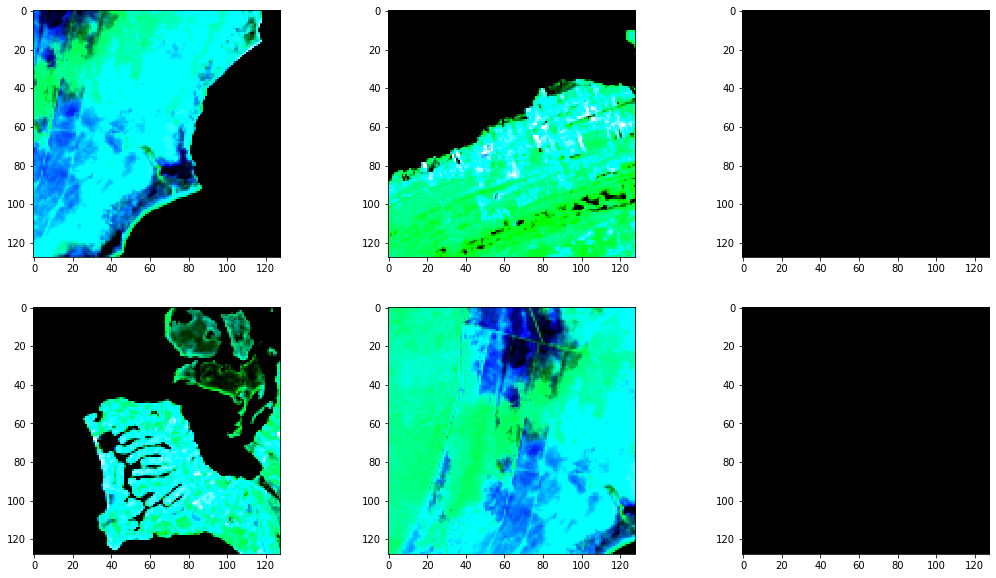

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10)) 

axs[0,0].imshow(im_batch[0,:,:,3:6])
axs[0,1].imshow(im_batch[1,:,:,3:6])
axs[0,2].imshow(im_batch[2,:,:,3:6])
axs[1,0].imshow(im_batch[3,:,:,3:6])
axs[1,1].imshow(im_batch[4,:,:,3:6])
axs[1,2].imshow(im_batch[5,:,:,3:6])

#fig.show()
plt.show()


### Explore the data:

#### Generate training dataset of 1x1 tiles for scikit-learn to visualize data

In [26]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label


Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 26)
----


Reshape because scikit-learn needs daya in `(samples, bands)` format:

In [27]:
im_batch[0,:,:,:]


array([[[-0.47515095, -0.43241988, -0.30422666, -0.40640966,
         -0.61727822, -0.65722248, -0.68880632]]])

In [28]:
im_batch_reshaped = im_batch.reshape(sample_size,7)
im_batch_reshaped[0]

array([-0.47515095, -0.43241988, -0.30422666, -0.40640966, -0.61727822,
       -0.65722248, -0.68880632])

#### Visualize Spectral Signatures

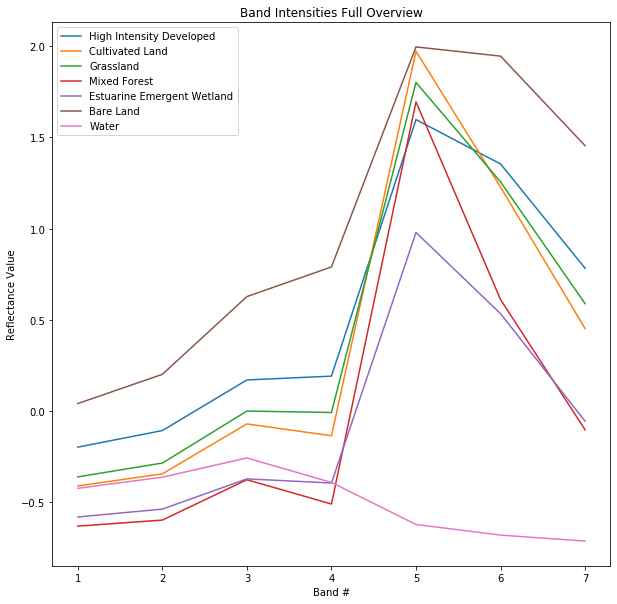

In [29]:
fig, ax = plt.subplots(1,1, figsize=[10,10])

# numbers 1-8
band_count = np.arange(1,8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


#### Run Principle Components Analysis to visualize points

In [30]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(im_batch_reshaped)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],
                   'pca-two':pca_result[:,1],
                   'pca-three':pca_result[:,2], 
                   'y' : np.argmax(label_batch, axis=1)})


Explained variation per principal component: [0.78340436 0.17950779 0.03281867]


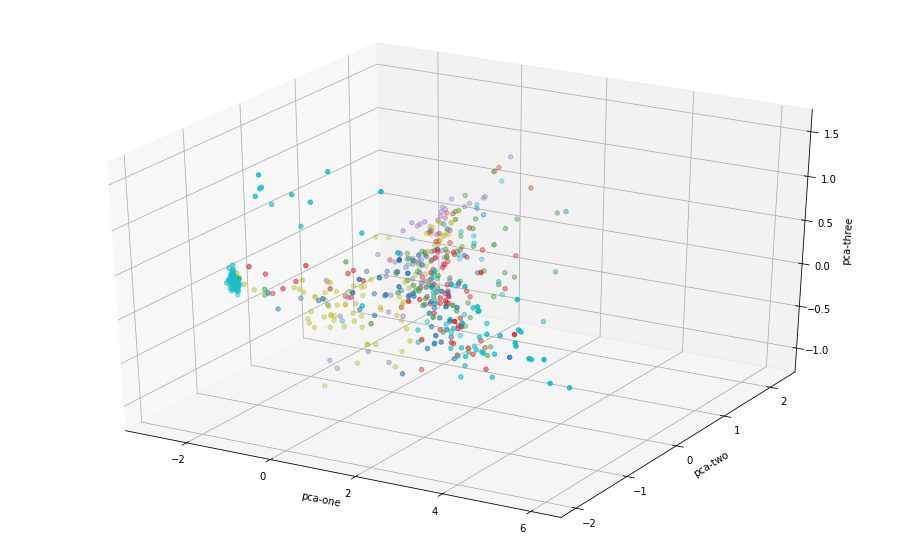

In [33]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()


#### Run T-distributed Stochastic Neighbor Embedding (t-SNE) to visualize points

In [34]:
from time import time
from sklearn.manifold import TSNE

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(im_batch_reshaped)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.663548
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.191807
[t-SNE] KL divergence after 1000 iterations: 0.196850
t-SNE done! Time elapsed: 7.764072895050049 seconds


In [35]:
df_subset = df.copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]


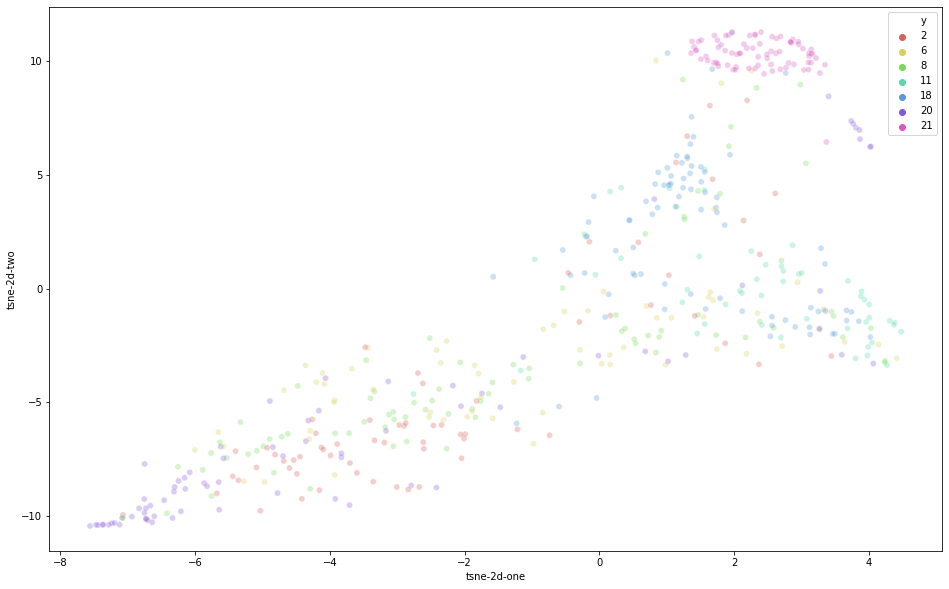

In [36]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(np.argmax(label_batch, axis=1)))),
    data=df_subset,
    legend="full",
    alpha=0.3
)


#### Generate training dataset of 1x1 tiles for scikit-learn to use in Random Forest and KNN

In [39]:
im_batch = None
label_batch = None

sample_size = 2000
train_count = 1500
val_count = 500

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

im_batch_reshaped = im_batch.reshape(sample_size,7)

X_train = im_batch_reshaped[:train_count]
X_val = im_batch_reshaped[train_count:]
y_train = np.argmax(label_batch, axis=1)[:train_count]
y_val = np.argmax(label_batch, axis=1)[train_count:]


Batch Shape
(2000, 1, 1, 7)
Label Shape
(2000, 26)
----


#### Run K Nearest Neighbors

In [41]:
from sklearn import neighbors, datasets

n_neighbors = 50

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)

clf.score(X_val, y_val)

# was 0.588


0.558

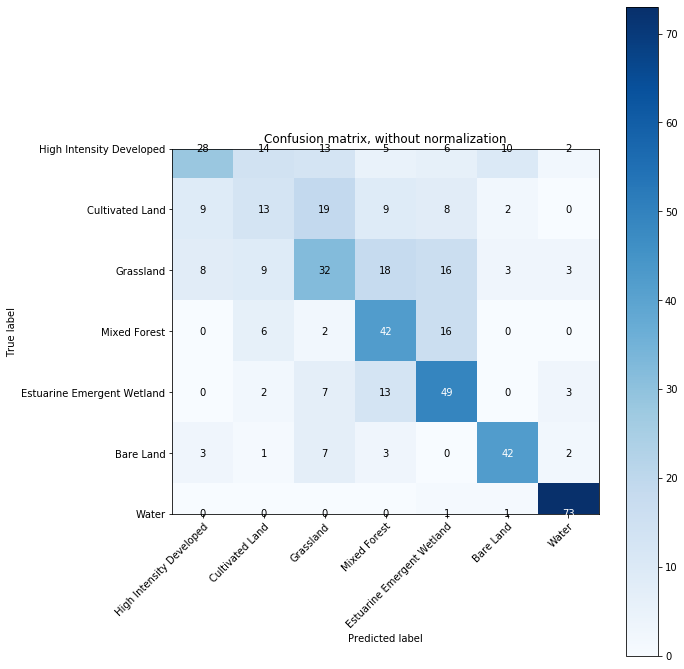

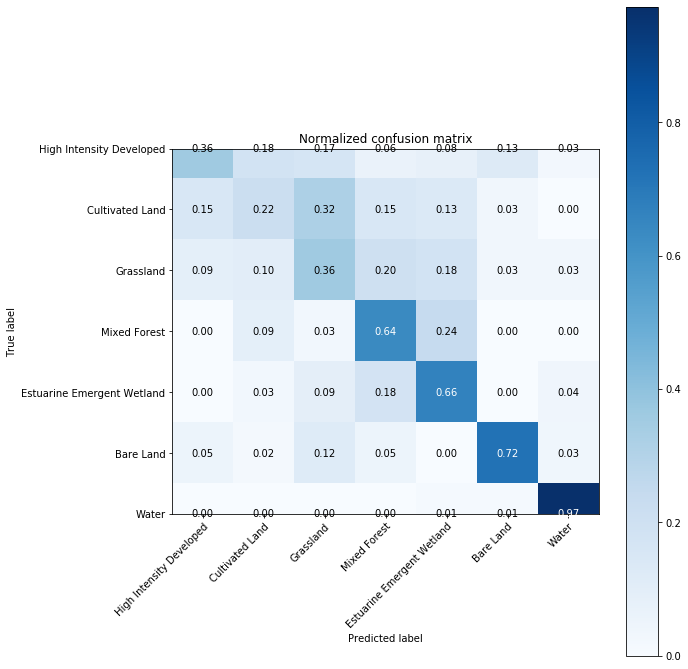

In [42]:
pred_index = clf.predict(X_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)


#### Run Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

print(rf.score(X_val, y_val))

# was 0.594


Our OOB prediction of accuracy is: 59.13333333333334%
0.582


In [1]:
pred_index = rf.predict(X_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)


NameError: name 'rf' is not defined

These models aren't terrible but they do mis-classify a good deal of the grassland, cultivated land, and developed land. Let's see if we can improve it!

### Building the actual neural network model

Import all the necessary `keras` packages

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint


Set the hyperparameters

In [39]:
batch_size = 25
epochs = 25
num_classes = len(class_names)

# input image dimensions
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count- 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)


(32, 32, 7)


#### Create the CNN architecture:

In [40]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()


W0627 22:16:19.156059 140718221567744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 22:16:19.168799 140718221567744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 22:16:19.171540 140718221567744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 22:16:19.215357 140718221567744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0627 22:16:19.216665 1407182215

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2048      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
__________

Divide data into training and validation:

In [41]:
train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("Train:", len(train_px), "\nVal:", len(val_px))


Train: 6400 
Val: 1600


Decide on the optimizier and compile the model:

In [42]:
sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)


W0627 22:16:19.927532 140718221567744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Learn the model:

<img src="https://i.imgur.com/vFCeROF.png" alt="drawing" width="500"/>

Image from the excellent *Deep Learning with Python* by François Chollet

W0627 22:16:20.019318 140718221567744 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
256/256 [==============================] - 23s 90ms/step - loss: 2.6154 - acc: 0.3056 - val_loss: 1.7839 - val_acc: 0.5806
Epoch 2/25
256/256 [==============================] - 22s 88ms/step - loss: 1.7736 - acc: 0.5355 - val_loss: 1.3813 - val_acc: 0.6356
Epoch 3/25
256/256 [==============================] - 22s 88ms/step - loss: 1.4736 - acc: 0.5833 - val_loss: 1.2598 - val_acc: 0.6300
Epoch 4/25
256/256 [==============================] - 23s 89ms/step - loss: 1.3163 - acc: 0.6042 - val_loss: 1.1345 - val_acc: 0.6456
Epoch 5/25
256/256 [==============================] - 22s 87ms/step - loss: 1.2269 - acc: 0.6211 - val_loss: 1.0658 - val_acc: 0.6694
Epoch 6/25
256/256 [==============================] - 22s 87ms/step - loss: 1.1496 - acc: 0.6347 - val_loss: 1.0324 - val_acc: 0.6544
Epoch 7/25
256/256 [==============================] - 21s 84ms/step - loss: 1.0852 - acc: 0.6439 - val_loss: 0.9785 - val_acc: 0.6731
Epoch 8/25
256/256 [==============================] - 21s 84ms

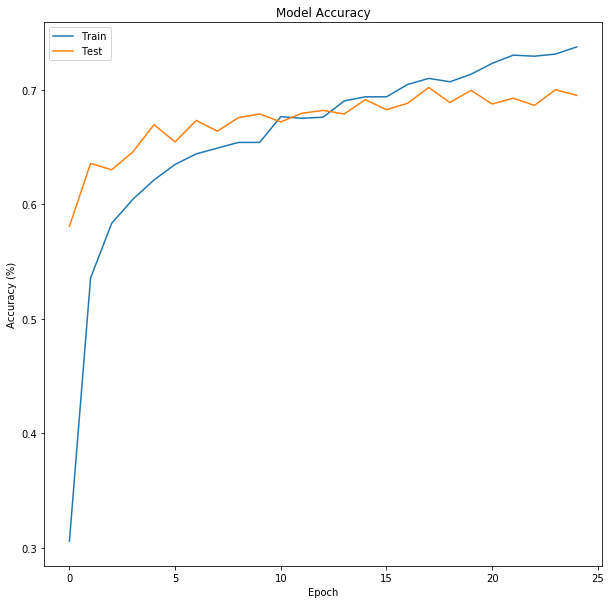

In [43]:
history = model.fit_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, train_px, batch_size, merge=True), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size, merge=True),
                    validation_steps=len(val_px) // batch_size)

plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


Hopefully we found our way down here:

<img src="https://science.sciencemag.org/content/sci/360/6388/478/F1.large.jpg" alt="drawing" width="500"/>

Image from: http://doi.org/10.1126/science.360.6388.478

#### Check out accuracy based on a confusion matrix:

64/64 [==============================] - 4s 56ms/step


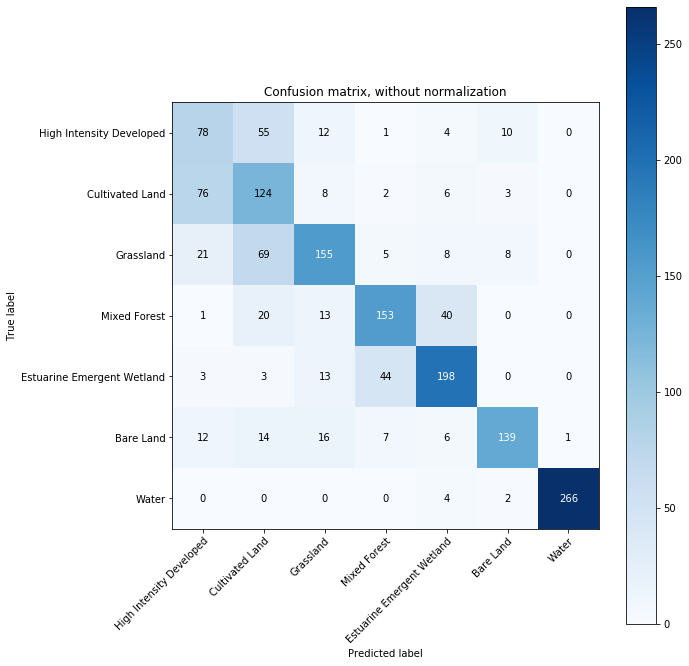

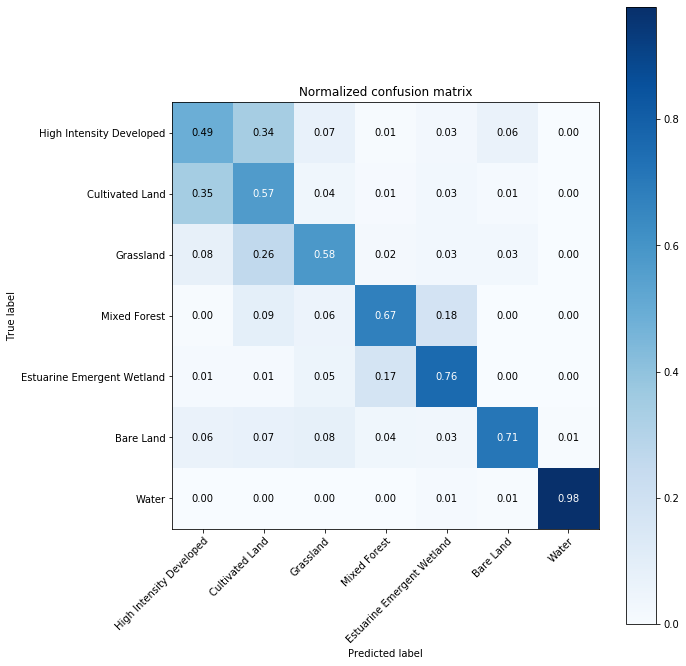

In [44]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size, merge=True), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size=1, merge=True)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)


How well does the model predict on the training data?

256/256 [==============================] - 14s 54ms/step


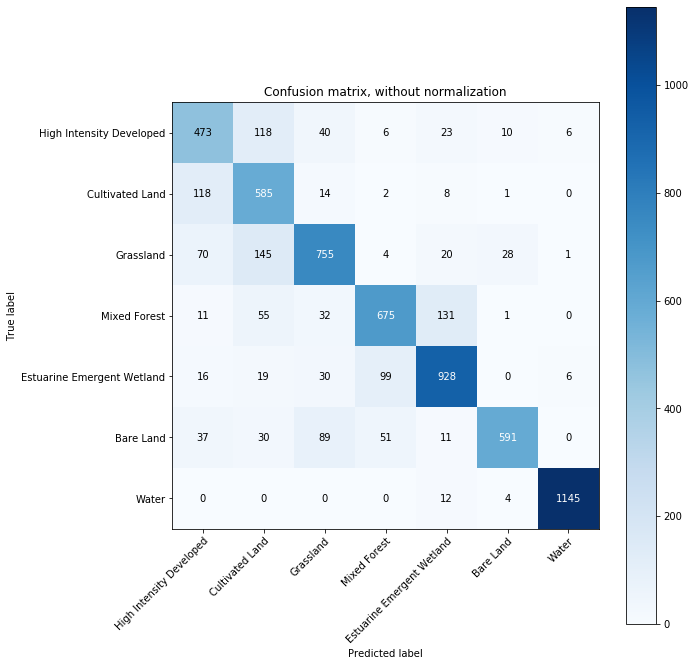

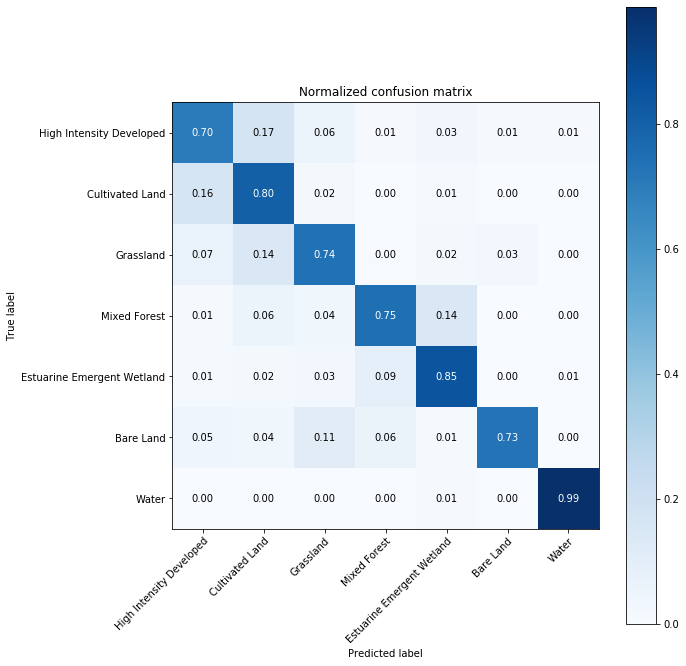

In [45]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, train_px, batch_size, merge=True), 
                        steps=len(train_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, train_px, batch_size=1, merge=True)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)


## Wrapup

We've now played with a number of data exploration techniques and seen how we can use `keras` to build a deep neural network for effective landcover classification. No small feat!

In the next chapter (link to [webpage](chapter_7_earth_engine_oceanography.html) or [Notebook](chapter_7_earth_engine_oceanography.ipynb)) we'll explore how we can use Google Earth Engine to process and download imagery for time series analysis.